In [1]:
#import modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import h5py
import tensorflow.compat.v1 as tf
import tensorflow as tf2

from DlModels import DlModels
from TrainDL import TrainDL
from DataLoader_frames import DataLoader

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
physical_devices = tf.config.list_physical_devices
print(physical_devices)

<function list_physical_devices at 0x7efd240dc7b8>


In [4]:
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.set_floatx('float32') #for memory use

In [ ]:
data_loader = DataLoader('frame_17_point_centered.hdf5')
%matplotlib inline  
i=0
obj = []
for image, output in data_loader.load_all():
    if i==0:
        obj = plt.imshow(image[:,:,0])
    else:
        obj.set_data(image)
    plt.show()


In [2]:
#import modules
epochs = 10
batch_size = 50
base_learning_rate = 0.0005
learning_decay_rate = 5
learning_decay_factor = 0.75
data_loader = DataLoader('frame_17_point_centered.hdf5')
data_loader.divide_data(train_percentage=0.9, valid_percentage=0.05, test_percentage=0.05)

tf.compat.v1.disable_eager_execution()
input_image = tf.placeholder(tf.float32, [None, 260, 346, 3], name='input_image')
grount_truth = tf.placeholder(tf.float32, [None, 18], name='ground_truth')
learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

sess = tf.Session()

# Build NN using load_vgg, layers, and optimize function
nn_last_layer = DlModels.FullyConnectedCL(input_image, encoder=DlModels.Conv2Dx3, N_outputs=18)

#train_op, loss = TrainDL.SoftEntropy(nn_last_layer, grount_truth, learning_rate)
train_op, loss = TrainDL.SoftEntropy(nn_last_layer, grount_truth, learning_rate)

#accuracy
correct_prediction = tf.equal(tf.argmax(nn_last_layer, 1), tf.argmax(grount_truth, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy_operation')



In [3]:
# Train NN using the train_nn function
tf.glorot_uniform_initializer()
TrainDL.train_nn(sess, epochs, nn_last_layer, batch_size, data_loader, accuracy_op, train_op, loss, input_image, grount_truth, learning_rate, base_learning_rate, learning_decay_rate, learning_decay_factor)
        
# save trained model
saver = tf.train.Saver()
saver.save(sess, './model')

Training...

EPOCH 1 ...
Loss 151.34188594818116 ...
Train Accuracy 0.07207142803817987 ...
Validation Accuracy [0.25688073] ...
EPOCH 2 ...
Loss 124.14715633392333 ...
Train Accuracy 0.36978571601212024 ...
Validation Accuracy [0.4587156] ...
EPOCH 3 ...
Loss 110.92120523452759 ...
Train Accuracy 0.5571666717529297 ...
Validation Accuracy [0.6055046] ...
EPOCH 4 ...
Loss 101.7631446838379 ...
Train Accuracy 0.618666672706604 ...
Validation Accuracy [0.6146789] ...
EPOCH 5 ...
Loss 92.92883911132813 ...
Train Accuracy 0.686357145011425 ...
Validation Accuracy [0.7155963] ...
EPOCH 6 ...
Loss 86.94815721511841 ...
Train Accuracy 0.8087380975484848 ...
Validation Accuracy [0.6972477] ...
EPOCH 7 ...
Loss 82.66644687652588 ...
Train Accuracy 0.7861190497875213 ...
Validation Accuracy [0.74311924] ...
EPOCH 8 ...
Loss 78.84836406707764 ...
Train Accuracy 0.8809285700321198 ...
Validation Accuracy [0.74311924] ...
EPOCH 9 ...
Loss 75.35723676681519 ...
Train Accuracy 0.8731190383434295 ...


'./model'

In [3]:
sess = tf.Session()
tf.disable_eager_execution()
saver = tf.train.import_meta_graph('./model.meta')
[n.name for n in tf.get_default_graph().as_graph_def().node]
g = tf.train.latest_checkpoint('./')
saver.restore(sess, tf.train.latest_checkpoint('./')) 

accuracy_op = tf.get_default_graph().get_tensor_by_name("accuracy_operation:0")

input_image = tf.get_default_graph().get_tensor_by_name("input_image:0")
grount_truth = tf.get_default_graph().get_tensor_by_name('ground_truth:0')
nn_last_layer = tf.get_default_graph().get_tensor_by_name("nn_last_layer:0")

INFO:tensorflow:Restoring parameters from ./model


In [4]:
sess = tf.Session()
tf.disable_eager_execution()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('./')) 

INFO:tensorflow:Restoring parameters from ./model


In [4]:
#data_loader = DataLoader('frame_17_point_centered.hdf5')
#data_loader.divide_data(train_percentage=0.9, valid_percentage=0.05, test_percentage=0.05)
#data_loader.divide_data()
x_test, y_test, test_size = data_loader.get_test_data()

test_accuracy = sess.run([accuracy_op],
                    feed_dict={input_image: x_test, grount_truth: y_test})
print(test_accuracy)

[0.7818182]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


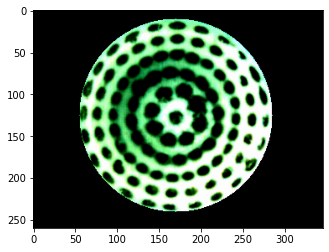

truth:  1
prediction:  1


In [5]:
#Test and visualize output
idx = 37

input_x = x_test[idx]
truth_class = np.argmax(y_test[idx])

NN_output = sess.run([nn_last_layer], feed_dict={input_image: [input_x]})

NN_prediction = np.argmax(NN_output)

plt.imshow((input_x))
plt.show()
print("truth: ", truth_class)
print("prediction: ", NN_prediction)

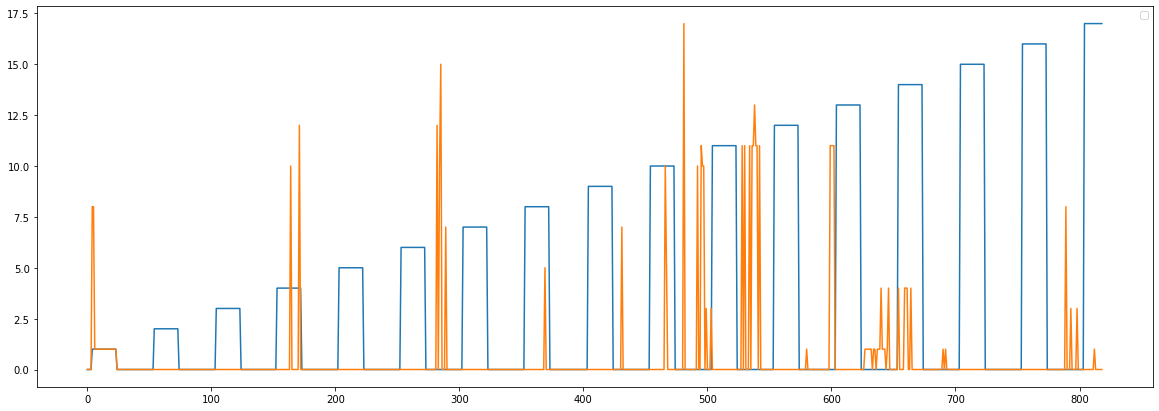

In [9]:
#run full sequence

initial_hidden_state_value = np.zeros(shape=(1, 29, 39, 20), dtype=float)
initial_carry_state_value = np.zeros(shape=(1, 29, 39, 20), dtype=float)

truth_list = []
prediction_list = []
prev_truth = 0
fall_counter = 0
initiate_counter = False

for image, contact_status in data_loader.get_full_data_sequence():
    
    #print(np.shape(image))
    
    last_layer, final_hidden_state, final_carry_state = sess.run([nn_last_layer, hidden_state, carry_state], 
                                feed_dict={input_image: image, initial_hidden_state: initial_hidden_state_value, initial_carry_state: initial_carry_state_value})
        
    truth_list.append(contact_status) 
    prev_truth = contact_status
    
    
    prediction = np.argmax(last_layer.reshape(-1), 0)   
    prediction_list.append(prediction)


    if (prev_truth > 0) and contact_status==0:
        initiate_counter = True

    if initiate_counter and contact_status==0:
        fall_counter = fall_counter + 1
    elif contact_status!=0:
        initiate_counter = False
        fall_counter = 0

    if fall_counter > 4:
        initial_hidden_state_value = np.zeros(shape=(1, 29, 39, 20), dtype=float)
        initial_carry_state_value = np.zeros(shape=(1, 29, 39, 20), dtype=float)
        initiate_counter = False
        fall_counter = 0
    else:        
        initial_hidden_state_value = final_hidden_state    
        initial_carry_state_value = final_carry_state
    

plt.figure(figsize=(20,7))
plt.plot(truth_list)
plt.plot(prediction_list)
plt.legend('true', 'lstm')
plt.show()

In [ ]:
plt.imshow(x_train[idx][0])

In [ ]:
print(g.eval())

In [ ]:
x = tf2.ones(shape=(5, 3, 5))
print(tf.shape(x))
print(tf.shape(x[:,-1,:]))

In [5]:
logits = [[4.0, 2.0, 1.0], [0.0, 5.0, 1.0]]
labels = [[1.0, 0.0, 0.0], [0.0, 0.8, 0.2]]
tf2.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)



<tf.Tensor 'softmax_cross_entropy_with_logits_1/Reshape_2:0' shape=(2,) dtype=float32>